In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.autograd import Variable
import random

In [2]:
plt.ion()

In [3]:
cwd = os.getcwd()
datadir = '/'.join(cwd.split('/')[0:-1]) + '/FDR/groundtruth/'

allFiles = glob.glob(datadir + "*.xml")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    #print (file_)
    parsedXML = ET.parse( file_ )
    a=file_.split('/')
    a=a[len(a)-1]
    a=a.split('.xml')
    data = {}
    for k,el in enumerate(parsedXML.iterfind('./*')):
        data[k]=[a[0]+"_"+list(el.items()[0])[1]]
        for i in el.iterfind('*'):
            data[k].append(int(list(i.items()[0])[1]))
            for j in i.iterfind('*'):
                if (list(j.items()[0])[1]!=np.nan and list(j.items()[1])[1]!=np.nan):
                    data[k].append(int(list(j.items()[0])[1]))
                    data[k].append(int(list(j.items()[1])[1]))
    df = pd.DataFrame.from_dict(data, orient='index',columns = ['img_number', 'ID', 'lefteye_x', 'lefteye_y','righteye_x','righteye_y'])
    list_.append(df)
frame = pd.concat(list_,sort=False)
frame=frame.reset_index(drop=True)
frame=frame.drop([38074,38405],axis=0)
frame=frame.reset_index(drop=True)
frame.count()

img_number    176914
ID             72289
lefteye_x      72289
lefteye_y      72289
righteye_x     72289
righteye_y     72289
dtype: int64

In [4]:
a=np.where(frame['ID'].isnull(),0,1)
b=[]
#for i in range(len(a)):
#    if(a[i]==1):
#        b.append([0,1])
#    else:
#        b.append([1,0])
frame['human']=a

frame=frame.drop(['ID', 'lefteye_x', 'lefteye_y','righteye_x','righteye_y'],axis=1)
frame.count()

img_number    176914
human         176914
dtype: int64

In [5]:
def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)

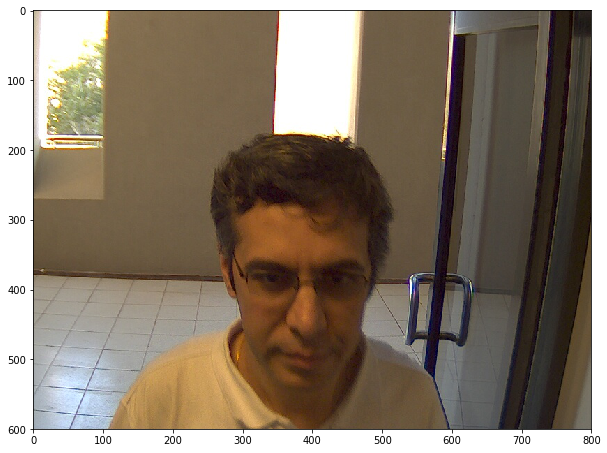

1


In [6]:
plt.figure(figsize=(10,8))
show_landmarks(io.imread(os.path.join('images','{}.jpg'.format(frame.loc[171]['img_number']))))
print (frame.loc[171]['human'])
plt.show()

In [7]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df=dataframe
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image=io.imread(os.path.join(self.img_dir,'{}.jpg'.format(frame.loc[idx]['img_number'])))
        if self.transform:
            image=self.transform(image)
        sample={'image':image,'y':self.df.loc[idx]['human']}
        return sample

In [8]:
face_Dataset=FaceDataset(dataframe=frame,img_dir='images/')

<Figure size 432x288 with 0 Axes>

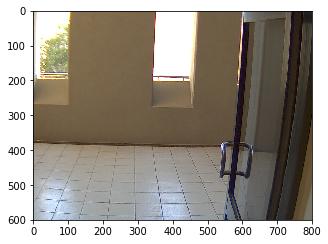

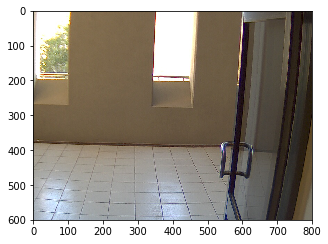

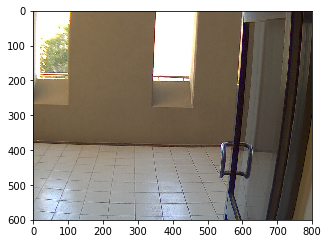

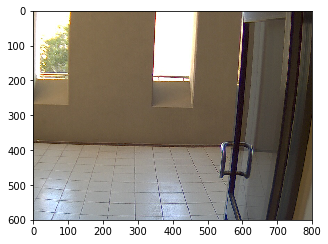

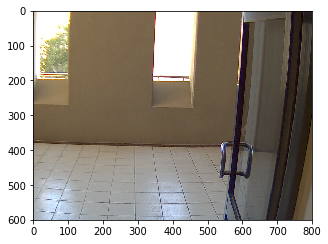

In [9]:
fig=plt.figure()
for i in range(100,105):
    sample=face_Dataset[i]
    plt.figure(figsize=(5,4))
    if(len(sample)>2):
        show_landmarks(sample['image'])
    else:
        plt.imshow(sample['image'])
plt.show()

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
transformed_dataset = FaceDataset(frame,img_dir='images/',transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize((120,160)),transforms.ToTensor()]))

In [12]:
for i in range(150,155):
    sample=transformed_dataset[i]
    print (i,sample['image'].shape,sample['y'])

150 torch.Size([3, 120, 160]) 1
151 torch.Size([3, 120, 160]) 1
152 torch.Size([3, 120, 160]) 1
153 torch.Size([3, 120, 160]) 1
154 torch.Size([3, 120, 160]) 1


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

1


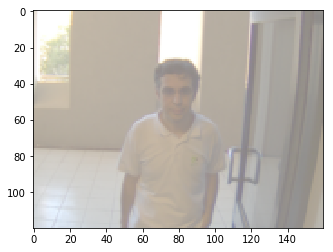

1


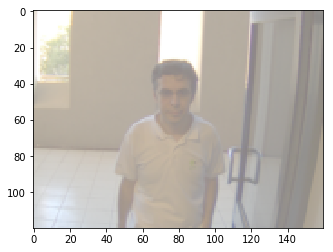

1


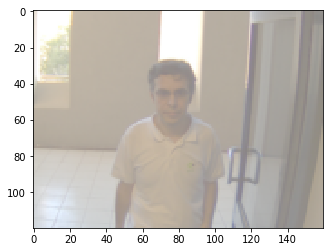

1


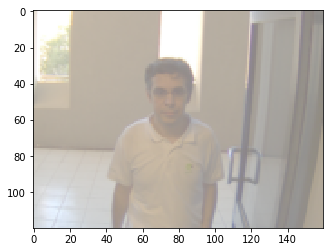

1


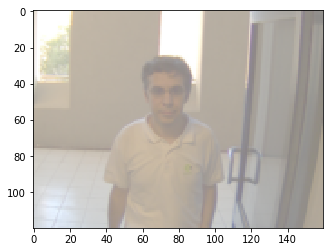

In [14]:
for i in range(150,155):
    sample=transformed_dataset[i]
    imshow(sample['image'])
    print (sample['y'])
    plt.show()

In [15]:
random.seed(0)

In [16]:
num_train=len(transformed_dataset)
indices=list(range(num_train))
split=36914
test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))

In [17]:
#train_data = SubsetRandomSampler(train_idx)
test_data = SubsetRandomSampler(test_idx)

In [18]:
#num_train=len(train_data)
#indices=list(range(num_train))
split=10000
validation_idx = np.random.choice(train_idx, size=split, replace=False)
train_idx = list(set(train_idx) - set(validation_idx))

In [19]:
train_data = SubsetRandomSampler(train_idx)
validation_data = SubsetRandomSampler(validation_idx)

In [20]:
len(train_data)

130000

In [21]:
len(validation_data)

10000

In [22]:
len(test_data)

36914

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=transformed_dataset, sampler=train_data,batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=transformed_dataset, sampler=validation_data,batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset=transformed_dataset, sampler=test_data, batch_size=100)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv=nn.Conv2d(3,15,11)
        self.pool=nn.MaxPool2d(2,2)
        self.ReLU=nn.ReLU()
        self.l1=nn.Linear(55*75*15,1000)
        self.l2=nn.Linear(1000,100)
        self.l3=nn.Linear(100,4)
        
    def forward(self,x):
        out=self.conv(x)
        out=self.pool(out)
        out=self.ReLU(out)
        out=out.view(-1,75*55*15)
        out=self.l1(out)
        out=self.ReLU(out)
        out=self.l2(out)
        out=self.ReLU(out)
        out=self.l3(out)
        #out=self.sigm(out)
        return out

In [36]:
model = Model()

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
print(device)

cuda:0


In [39]:
model=model.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.020)

In [42]:
num_epochs=6

Epoch [1/6], Step [1/10], Loss: 86.2269
Epoch [1/6], Step [2/10], Loss: 82.8387
Epoch [1/6], Step [3/10], Loss: 80.0639
Epoch [1/6], Step [4/10], Loss: 77.3656
Epoch [1/6], Step [5/10], Loss: 70.8928
Epoch [1/6], Step [6/10], Loss: 66.1982
Epoch [1/6], Step [7/10], Loss: 58.9107
Epoch [1/6], Step [8/10], Loss: 50.4183
Epoch [1/6], Step [9/10], Loss: 43.6732
Epoch [1/6], Step [10/10], Loss: 39.7437
Accuracy of the network: 0.910900 %
Epoch [2/6], Step [1/10], Loss: 34.5240
Epoch [2/6], Step [2/10], Loss: 28.6476
Epoch [2/6], Step [3/10], Loss: 28.3494
Epoch [2/6], Step [4/10], Loss: 28.9264
Epoch [2/6], Step [5/10], Loss: 26.3446
Epoch [2/6], Step [6/10], Loss: 25.5387
Epoch [2/6], Step [7/10], Loss: 22.6075
Epoch [2/6], Step [8/10], Loss: 23.3978
Epoch [2/6], Step [9/10], Loss: 21.1511
Epoch [2/6], Step [10/10], Loss: 20.3371
Accuracy of the network: 0.937400 %
Epoch [3/6], Step [1/10], Loss: 20.4043
Epoch [3/6], Step [2/10], Loss: 18.9015
Epoch [3/6], Step [3/10], Loss: 19.5890
Epoch 

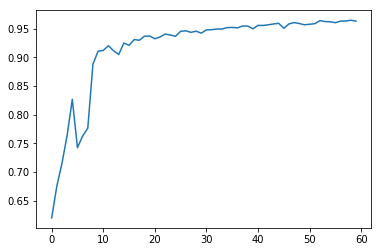

In [43]:
acc=[]
for epoch in range(num_epochs):
    runningloss=0
    for i,(sample) in enumerate(train_loader):
        #print ()
        images = Variable(sample['image'])
        images=images.to(device)
    #print (len(images))
        labels=Variable(sample['y'])
        labels=labels.to(device)
    
        optimizer.zero_grad()
        output=model(images)
        #_,pred=torch.max(output,1)
    
        loss=criterion(output,labels)
    #loss = Variable(loss, requires_grad = True)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        #print (i,runningloss)
        if (i+1) % 130 == 0:  
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, (i+1)/130,10 ,runningloss))
            runningloss=0
      
            correct=0
            total=0
            for samp in validation_loader:
                im = Variable(samp['image'])
                im=im.to(device)
                ot = model(im)
                _, predicted = torch.max(ot, 1)
                #_, samplab = torch.max(samp['y'].to(device), 1)
  
                total += samp['y'].size(0)
                correct += (predicted== samp['y'].to(device)).sum().item()
    
            acc.append(correct/total)
    print('Accuracy of the network: %f %%' %(acc[len(acc)-1]))

plt.plot(range(len(acc)),acc)


In [44]:
correct=0
total=0
tp=0
fp=0
fn=0
tn=0
pics=[]
for samp in test_loader:
    im = Variable(samp['image'])
    im=im.to(device)
    ot = model(im)
    _, predicted = torch.max(ot, 1)
    #_, samplab = torch.max(samp['y'].to(device), 1)
  
    total += samp['y'].size(0)
    correct += (predicted== samp['y'].to(device)).sum().item()
    samplab=samp['y'].to(device)
    
    #pics=pics+([samp[][i] for i in range(len(predicted)) if samplab[i]!=predicted[i]])
    tp=tp+len([i for i in range(len(predicted)) if samplab[i]==1 and predicted[i]==1])
    tn=tn+len([i for i in range(len(predicted)) if samplab[i]==0 and predicted[i]==0])
    fp=fp+len([i for i in range(len(predicted)) if samplab[i]==0 and predicted[i]==1])
    fn=fn+len([i for i in range(len(predicted)) if samplab[i]==1 and predicted[i]==0])
    
    
print('Accuracy of the network: %f %%' % (correct/total))
print('Precision of the network: %f %%' % (tp/(tp+fp)))
print('Recall/Sensitivity/TPR of the network: %f %%' % (tp/(tp+fn)))
print('TNR/Specifity/Selectivity of the network: %f %%' % (tn/(tn+fp)))


Accuracy of the network: 0.963645 %
Precision of the network: 0.952331 %
Recall/Sensitivity/TPR of the network: 0.959493 %
TNR/Specifity/Selectivity of the network: 0.966538 %


In [45]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv.weight 	 torch.Size([15, 3, 11, 11])
conv.bias 	 torch.Size([15])
l1.weight 	 torch.Size([1000, 61875])
l1.bias 	 torch.Size([1000])
l2.weight 	 torch.Size([100, 1000])
l2.bias 	 torch.Size([100])
l3.weight 	 torch.Size([2, 100])
l3.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.02, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140358229266864, 140358231258168, 140358231259536, 140358231257592, 140358231259320, 140358231257376, 140358231260040, 140358231258888]}]


In [46]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            },'Path.pth')